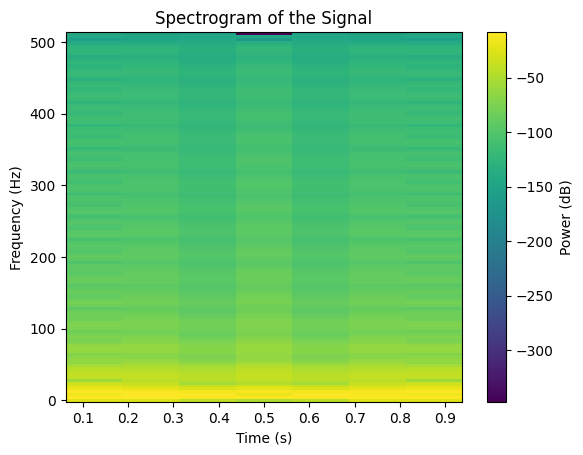

In [1]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import numpy as np

def signal_to_spectrogram(signal, fs=1024):
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256, noverlap=128)
    return f, t, Sxx

# Приклад використання

t = np.linspace(0, 1, 1024, endpoint=False)

sample_signal = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 10 * t)
f, t, Sxx = signal_to_spectrogram(sample_signal)

plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.title("Spectrogram of the Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Power (dB)")
plt.show()


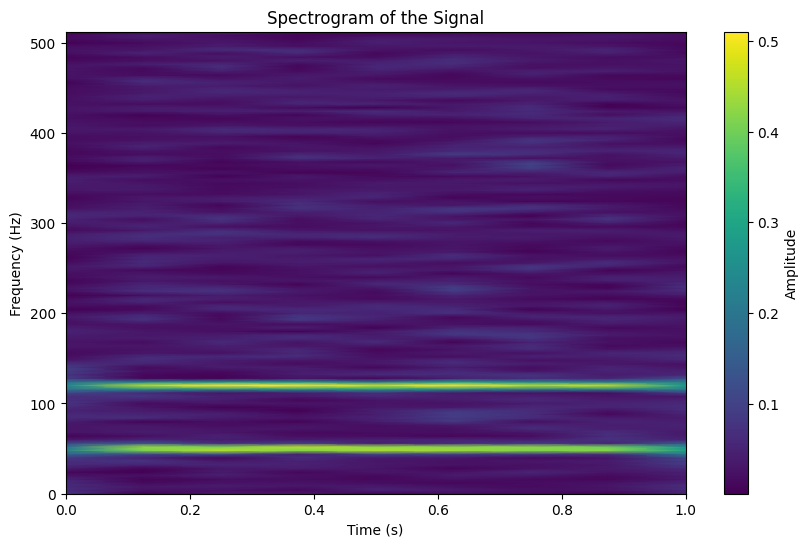

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

# Генерація тестового сигналу
t = np.linspace(0, 1, 1024, endpoint=False)  # Часова шкала
signal = np.sin(2 * np.pi * 50 * t) + np.sin(2 * np.pi * 120 * t)  # Сума синусоїд
noise = np.random.normal(0, 0.5, signal.shape)  # Шум
noisy_signal = signal + noise

# Розрахунок спектрограми за допомогою STFT
f, t, Zxx = stft(noisy_signal, fs=1024, nperseg=256, noverlap=128)

# Візуалізація спектрограми
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title("Spectrogram of the Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Amplitude")
plt.show()

In [5]:
from scipy.signal import stft, istft

# ISTFT
_, reconstructed_signal = istft(Zxx, fs=1024, nperseg=256, noverlap=128)

In [6]:
reconstructed_signal

array([-0.12681696,  1.31039644,  2.27665633, ..., -2.7718015 ,
       -2.33437888, -2.22878282], shape=(1024,))

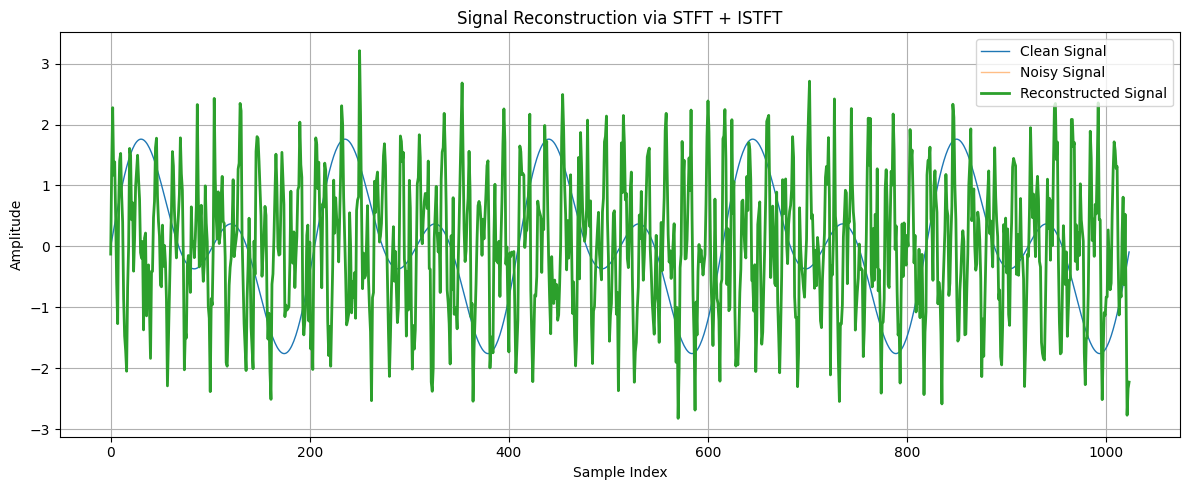

In [10]:
# Візуалізація
plt.figure(figsize=(12, 5))
plt.plot(sample_signal, label="Clean Signal", linewidth=1)
plt.plot(noisy_signal, label="Noisy Signal", linewidth=1, alpha=0.5)
plt.plot(reconstructed_signal, label="Reconstructed Signal", linewidth=2)
plt.legend()
plt.title("Signal Reconstruction via STFT + ISTFT")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

✅ Model loaded.


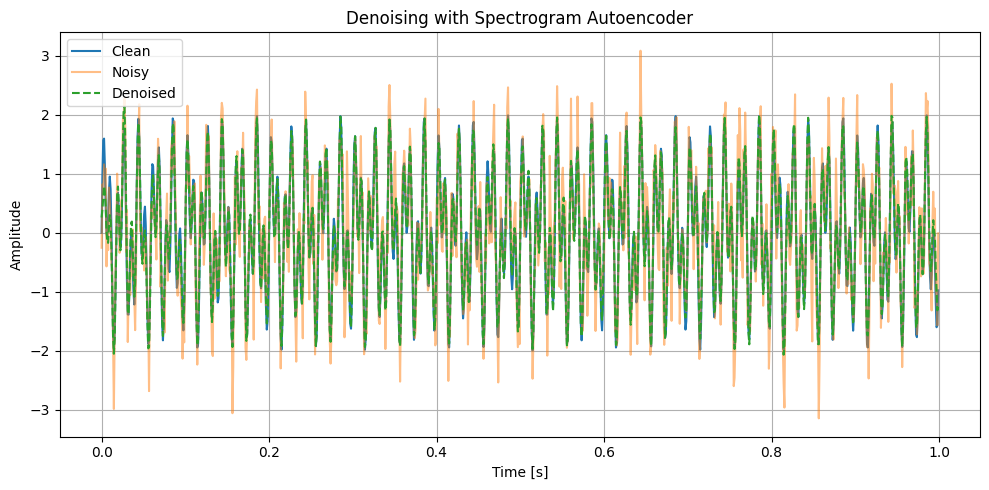

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
from models.autoencoder_spectr import *

# ─── КОНСТАНТИ ────────────────────────────────────────────────────────────────
FS = 1024        # частота дискретизації
SIGNAL_LEN = 1024
NPERSEG = 256
NOVERLAP = NPERSEG // 2
PAD = NPERSEG // 2

# ─── ФУНКЦІЇ ПЕРЕТВОРЕННЯ ────────────────────────────────────────────────────

def signal_to_spectrogram(signal):
    """
    1) дзеркально допадимо по краях
    2) зробимо STFT
    """
    sig = np.pad(signal, PAD, mode='reflect')
    _, _, Zxx = stft(sig, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP)
    mag = np.abs(Zxx)
    return mag, Zxx

def spectrogram_to_signal(Zxx_complex):
    """
    1) зробимо ISTFT
    2) обріжемо паддінг назад
    """
    _, rec = istft(Zxx_complex, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP)
    # обрізаємо віддзеркалені PAD точок на початку й кінці
    rec = rec[PAD : PAD + SIGNAL_LEN]
    return rec


# 1. Ініціалізація пристрою
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Завантаження ваг
# (зверніть увагу: частоти/тайм-фрейми мають збігатися з тренуванням)
# Щоб взнати розміри: mag, _ = signal_to_spectrogram(np.zeros(SIGNAL_LEN))
mag_sample, _ = signal_to_spectrogram(np.zeros(SIGNAL_LEN))
fb, tf = mag_sample.shape
model = SpectrogramVAE(fb, tf).to(device).to(device)
model.load_state_dict(torch.load('models/spectrogram_vae.pth', map_location=device))
print("✅ Model loaded.")

# 3. Генерація тестового сигналу
t = np.linspace(0, 1, SIGNAL_LEN, endpoint=False)
clean = np.sin(2*np.pi*50*t) + np.sin(2*np.pi*120*t)
noise = np.random.normal(0, 0.5, clean.shape)
noisy = clean + noise

# 4. Деноїзинг
denoised = denoise_with_vae(noisy, model, device)

# 5. Візуалізація
plt.figure(figsize=(10,5))
plt.plot(t, clean, label='Clean')
plt.plot(t, noisy, label='Noisy', alpha=0.5)
plt.plot(t, denoised, label='Denoised', linestyle='--')
plt.legend()
plt.title('Denoising with Spectrogram Autoencoder')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
denoised

array([ 0.26126198,  0.39996774,  0.59556093, ..., -0.94120153,
       -1.31209593, -1.2479424 ], shape=(1024,))

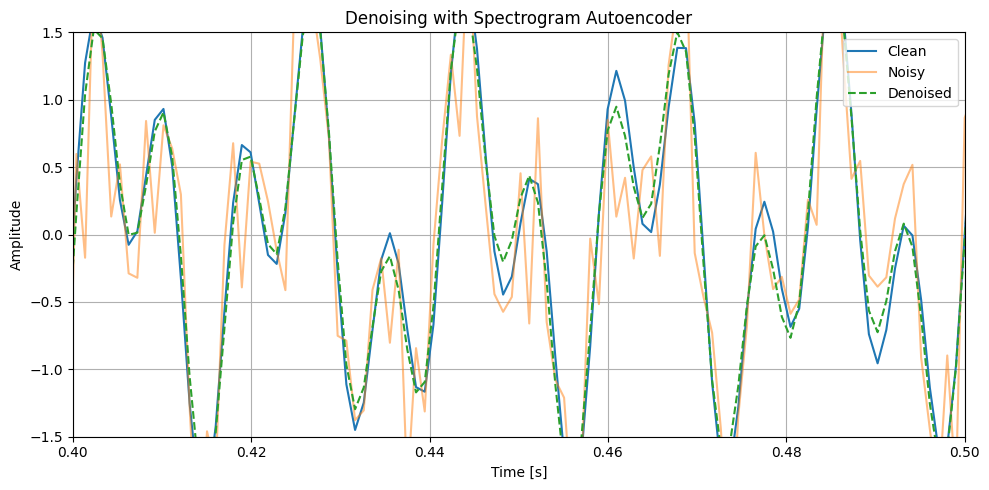

In [3]:
# 5. Візуалізація
plt.figure(figsize=(10,5))
plt.plot(t, clean, label='Clean')
plt.plot(t, noisy, label='Noisy', alpha=0.5)
plt.plot(t, denoised, label='Denoised', linestyle='--')
plt.legend()
plt.title('Denoising with Spectrogram Autoencoder')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(0.4, 0.5)
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.tight_layout()
plt.show()